# Weather History 

## `00 ` Import libraries 

In [359]:
import numpy as np
import pandas as pd
# visulaization
import matplotlib.pyplot as plt
import seaborn as sns

#check normality
from scipy.stats import shapiro
#for Normalization
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
#spliting data
from sklearn.model_selection import train_test_split
#models
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score
import random
pd.set_option('display.max_columns', None)


## `01 ` Read Data 

In [360]:
df = pd.read_csv("weather_classification.csv")
# df = df.sample(frac = 1)
df.head(3)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,NW,6.0,20,68,29,1019.7,1015.0,7,7,14.4,23.6,No,3.6,Yes
1,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,W,4.0,17,80,36,1012.4,1008.4,5,3,17.5,25.7,Yes,3.6,Yes
2,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,NNE,6.0,6,82,69,1009.5,1007.2,8,7,15.4,20.2,Yes,39.8,Yes


## `02` EDA

In [361]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        366 non-null    float64
 1   MaxTemp        366 non-null    float64
 2   Rainfall       366 non-null    float64
 3   Evaporation    366 non-null    float64
 4   Sunshine       363 non-null    float64
 5   WindGustDir    363 non-null    object 
 6   WindGustSpeed  364 non-null    float64
 7   WindDir9am     335 non-null    object 
 8   WindDir3pm     365 non-null    object 
 9   WindSpeed9am   359 non-null    float64
 10  WindSpeed3pm   366 non-null    int64  
 11  Humidity9am    366 non-null    int64  
 12  Humidity3pm    366 non-null    int64  
 13  Pressure9am    366 non-null    float64
 14  Pressure3pm    366 non-null    float64
 15  Cloud9am       366 non-null    int64  
 16  Cloud3pm       366 non-null    int64  
 17  Temp9am        366 non-null    float64
 18  Temp3pm   

In [362]:
cat_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
num_cols = list(set(df.columns.to_list()) - set(['index', 'RainTomorrow'] + cat_cols))

### `2.1` Check Normality

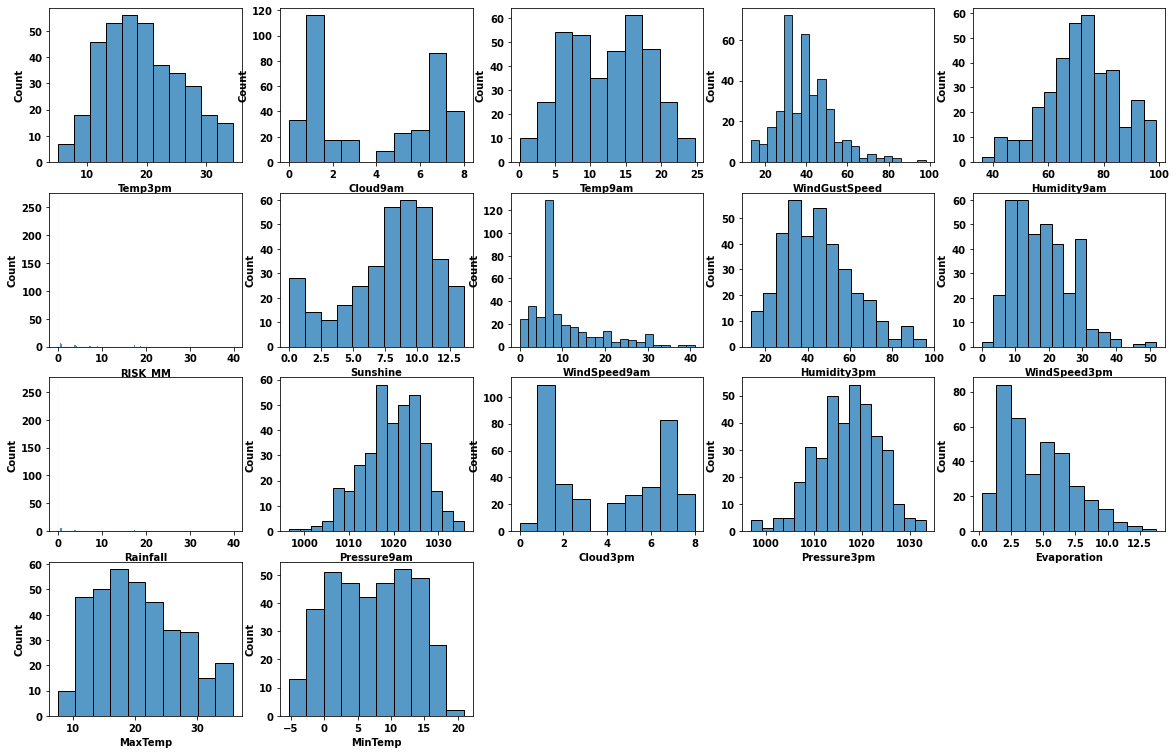

In [363]:

plt.figure(figsize=(20,30))
for i, col in enumerate(df[num_cols]):
    ax = plt.subplot(9, 5, i+1)
    sns.histplot(df[col], ax=ax)
plt.show()

### `2.2` Check Nulls

In [364]:
nulls_df = ((df.isna().sum()/df.shape[0])*100).sort_values(ascending=False).reset_index().rename(columns = { 0 : "Nulls_Count"})
nulls_df[nulls_df['Nulls_Count'] > 0]


,index,Nulls_Count
0,WindDir9am,8.469945
1,WindSpeed9am,1.912568
2,Sunshine,0.819672
3,WindGustDir,0.819672
4,WindGustSpeed,0.546448
5,WindDir3pm,0.273224


### `2.3` Check Duplicates

In [365]:
#check Duplicates
df.duplicated().sum()

0

### `2.4` Check Outliers

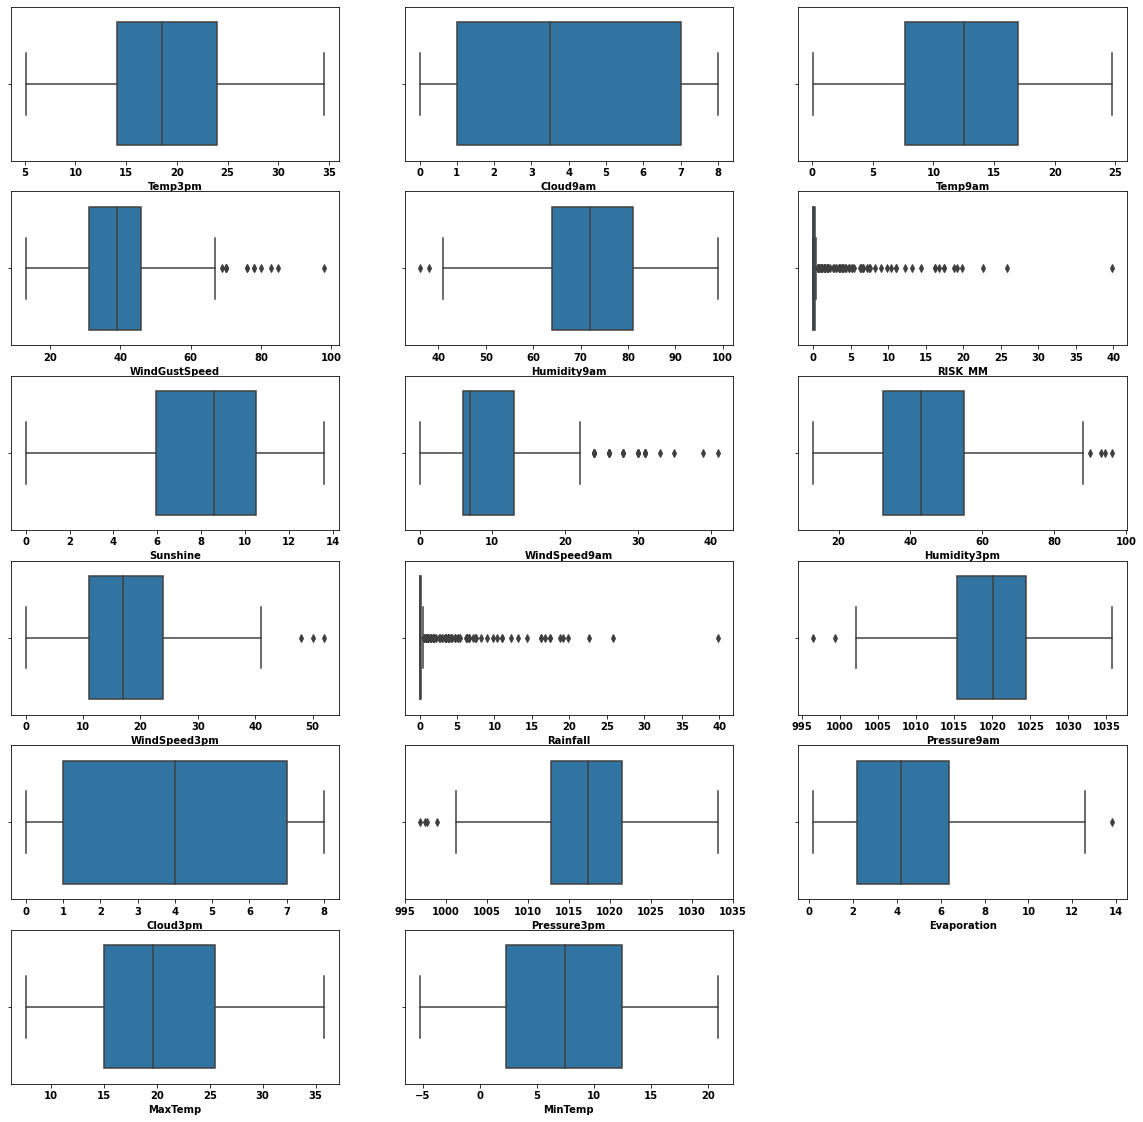

In [366]:
#Check Outliers
plt.figure(figsize=(20,30))
for i, col in enumerate(df[num_cols]):
    plt.subplot(9, 3, i+1)
    sns.boxplot(x = df[col]) 
plt.show()


### `2.5` Check Highly correlated features

<AxesSubplot:>

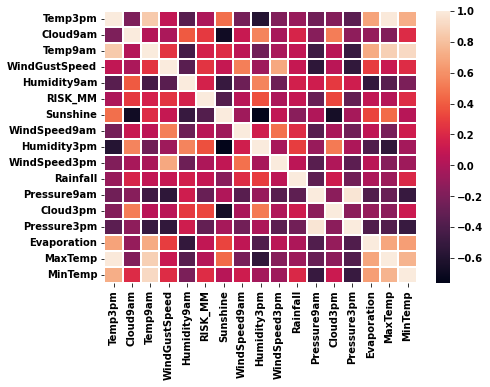

In [367]:
# making a heatmap to inspect the highly correlated features
import seaborn as sns
corr_matrix = df[num_cols].corr()
plt.subplots(figsize = (7, 5))
sns.heatmap(corr_matrix, 
           xticklabels = corr_matrix.columns.values,
           yticklabels = corr_matrix.columns.values, 
           linewidth = 0.1)

### `2.6` Categorical Features

In [368]:
df['RainToday'].value_counts()


No     300
Yes     66
Name: RainToday, dtype: int64

In [369]:
df['WindGustDir'].value_counts()

NW     73
NNW    44
E      37
WNW    35
ENE    30
ESE    23
S      22
N      21
W      20
NE     16
SE     12
SSE    12
NNE     8
SSW     5
SW      3
WSW     2
Name: WindGustDir, dtype: int64

In [370]:
df['WindDir9am'].value_counts()

SE     47
SSE    40
NNW    36
N      31
NW     30
ESE    29
S      27
E      22
SSW    17
WNW    16
W       8
NNE     8
ENE     8
SW      7
WSW     5
NE      4
Name: WindDir9am, dtype: int64

In [371]:
df['WindDir3pm'].value_counts()

NW     61
WNW    61
NNW    47
N      30
ESE    27
W      26
E      17
NE     15
S      14
NNE    14
ENE    13
SE     12
WSW    11
SSE     7
SSW     6
SW      4
Name: WindDir3pm, dtype: int64

### `2.7` Check if Imbalanced

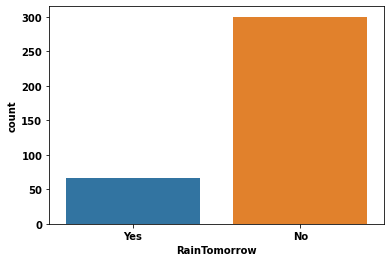

In [372]:
# Check number of samples in each class
_ = sns.countplot(x='RainTomorrow', data=df)

 
> ### **Observations :**
> Data have : 
> 1. Nulls
> 2. Corrolated Features
> 3. Skewness
> 4. Outliers <br>
> 5. Imbalanced




## `03` Data Preprocessing

#### `3.1` Handling Nulls

In [373]:
## columns which have more than 60% of the data NULL values should be dropped
df['WindDir9am'] = df['WindDir9am'].fillna(df['WindDir9am'].mode()[0])
df['WindSpeed9am'] = df['WindSpeed9am'].fillna(df['WindSpeed9am'].median())

## when the number of nulls in a row is very small, we can simply drop this small number of rows
features_with_rows_to_be_dropped = ['Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir3pm']
df = df.dropna(axis=0, subset=features_with_rows_to_be_dropped)

# Re-check null values
df.isna().sum().sum()

0

#### `3.2` Dropping duplicates

In [374]:
df = df.drop_duplicates()

#### `3.3` Handling Categorical Data

In [375]:
# Binary encoding for categorical data
import category_encoders as ce
df['RainTomorrow'] = df['RainTomorrow'].replace({'Yes': 1, 'No': 0})


binaryEncoder = ce.BinaryEncoder()
encoded_df = pd.concat([df, binaryEncoder.fit_transform(df[cat_cols])], axis=1)
encoded_df.drop(columns=['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday'], inplace=True)
encoded_df.head(5)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM,RainTomorrow,WindGustDir_0,WindGustDir_1,WindGustDir_2,WindGustDir_3,WindGustDir_4,WindDir9am_0,WindDir9am_1,WindDir9am_2,WindDir9am_3,WindDir9am_4,WindDir3pm_0,WindDir3pm_1,WindDir3pm_2,WindDir3pm_3,WindDir3pm_4,RainToday_0,RainToday_1
0,8.0,24.3,0.0,3.4,6.3,30.0,6.0,20,68,29,1019.7,1015.0,7,7,14.4,23.6,3.6,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1
1,14.0,26.9,3.6,4.4,9.7,39.0,4.0,17,80,36,1012.4,1008.4,5,3,17.5,25.7,3.6,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
2,13.7,23.4,3.6,5.8,3.3,85.0,6.0,6,82,69,1009.5,1007.2,8,7,15.4,20.2,39.8,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,1,1,0
3,13.3,15.5,39.8,7.2,9.1,54.0,30.0,24,62,56,1005.5,1007.0,2,7,13.5,14.1,2.8,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
4,7.6,16.1,2.8,5.6,10.6,50.0,20.0,28,68,49,1018.3,1018.5,7,7,11.1,15.4,0.0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,0,0,1,0


#### `3.3` Handling Imbalanced Data

In [376]:
# encoded_df = encoded_df.sample(frac = 1)
train_data, validation_data = train_test_split(encoded_df, test_size = 0.2, random_state = 42)
print(f'train_data : ', train_data.shape)
print(f'validation_data : ', validation_data.shape)

train_data :  (287, 35)
validation_data :  (72, 35)


In [377]:
Y_train = train_data[['RainTomorrow']]
X_train = train_data.loc[:, train_data.columns!='RainTomorrow']

In [378]:
# Applying over/under sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

under = RandomUnderSampler(sampling_strategy = {0:150}, random_state=42)
X_train ,Y_train = under.fit_resample(X_train ,Y_train)
over = SMOTE(sampling_strategy = {1:150}, k_neighbors=4, random_state=42)
X_res, y_res = over.fit_resample(X_train ,Y_train)

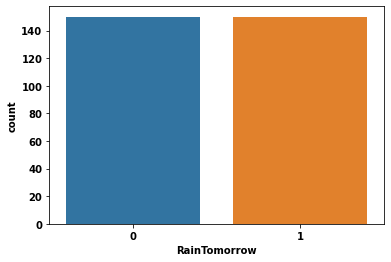

In [379]:
_ = sns.countplot(x='RainTomorrow', data=y_res)
train_data = pd.concat([X_res, y_res], axis = 1)

#### `3.4` Handling Highly Corrolated Features

In [380]:
def handling_highlyCorrolatedFeatures (train_data, validation_data, num_cols, target, threshold = 0.7):
    num_cols_wthout_response_var = list(set(num_cols) - set([target]))
    cor_matrix = train_data[num_cols_wthout_response_var].corr().abs()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    train_data = train_data.drop(columns = to_drop)
    validation_data = validation_data.drop(columns = to_drop)
    return train_data, validation_data


#### `3.5` Handling Outliers

In [381]:
def bounds_calc(train_data, col, boundry_threshold):
  Q1 = np.percentile(train_data[col], q = 25, interpolation = 'midpoint')
  Q3 = np.percentile(train_data[col], q = 75, interpolation = 'midpoint')
  IQR = Q3 - Q1
  Upper_Bound = Q3 + boundry_threshold * IQR
  Lower_Bound = Q1 - boundry_threshold * IQR
  return Lower_Bound, Upper_Bound
    
def outliers_clamping(Lower_Bound, Upper_Bound, value):
  if value > Upper_Bound:
    return Upper_Bound
  elif value < Lower_Bound:
    return Lower_Bound
  else:
    return value

def outliers_handling(train_data, validation_data, boundry_threshold):
    num_data = list(set(train_data.select_dtypes(exclude=[object]).columns) )
    for col in num_data:
        Lower_Bound, Upper_Bound = bounds_calc(train_data, col, boundry_threshold)
        train_data[col] = train_data[col].apply(lambda x : outliers_clamping(Lower_Bound, Upper_Bound, x))
        validation_data[col] = validation_data[col].apply(lambda x : outliers_clamping(Lower_Bound, Upper_Bound, x))
    return train_data, validation_data

#### `3.6` Handling Skewness

In [382]:
def skewness_calc(col ,df):
    std_col = np.std(df[col])
    mean_col = np.mean(df[col])
    size_rows = df.count()[0]
    skewness = np.sum(np.power(df[col] - mean_col, 3))/((size_rows - 1) * np.power(std_col, 3))
    return skewness

def skewed_data_transformation(value):
  return np.log(1 + np.abs(value))

def skewness_handling(train_data, validation_data):
    num_data = list(set(train_data.select_dtypes(exclude=[object]).columns))
    skewed_train_cols = []
    for col in num_data: 
        sk = skewness_calc(col, train_data)
        if (np.abs(sk) >= 1):
            skewed_train_cols.append(col)
            train_data[col] = train_data[col].apply(lambda x : skewed_data_transformation(x))
            validation_data[col] = validation_data[col].apply(lambda x : skewed_data_transformation(x))
    return train_data, validation_data

#### `3.7` Feature Scaling

##### `3.7.1 ` Shapiro-Wilk(Normal Distribution) test

In [383]:
def Shapiro_Wilk_test (df, num_cols, alpha):
    feats_std_scale = []
    feats_min_max_scale = []
    for col in num_cols:
        stat, p = shapiro(df[col])
        if p > alpha:
            feats_std_scale.append(col)
        else:
            feats_min_max_scale.append(col)
    return feats_min_max_scale, feats_std_scale

##### `3.7.2 ` Scaling Features

In [384]:
# brute force code , Don't forget to enhance ittttttt  ----------------->
def scaling_features (train_data, validation_data, alpha):
    num_data = list(set(train_data.select_dtypes(exclude=[object]).columns) - set(['Id']))
    feats_min_max_scale, feats_std_scale = Shapiro_Wilk_test(train_data, num_data, alpha)
    
    if len(feats_std_scale) <= 0  :
        min_max_scaler = MinMaxScaler()
        min_max_scaler_model = min_max_scaler.fit(train_data[feats_min_max_scale])
        min_max_scaled_train_data = pd.DataFrame(min_max_scaler_model.transform(train_data[feats_min_max_scale]), columns = feats_min_max_scale)
        min_max_scaled_validation_data = pd.DataFrame(min_max_scaler_model.transform(validation_data[feats_min_max_scale]), columns = feats_min_max_scale)
        num_train_data = min_max_scaled_train_data
        num_validation_data = min_max_scaled_validation_data
    elif len(feats_min_max_scale) <= 0 :
        std_scaler = StandardScaler()
        std_scaler_model = std_scaler.fit(train_data[feats_std_scale])
        std_scaled_train_data = pd.DataFrame(std_scaler_model.transform(train_data[feats_std_scale]), columns = feats_std_scale)
        std_scaled_validation_data = pd.DataFrame(std_scaler_model.transform(validation_data[feats_std_scale]), columns = feats_std_scale)
        num_train_data = std_scaled_train_data
        num_validation_data = std_scaled_validation_data
    else : 
        min_max_scaler = MinMaxScaler()
        min_max_scaler_model = min_max_scaler.fit(train_data[feats_min_max_scale])
        min_max_scaled_train_data = pd.DataFrame(min_max_scaler_model.transform(train_data[feats_min_max_scale]), columns = feats_min_max_scale)
        min_max_scaled_validation_data = pd.DataFrame(min_max_scaler_model.transform(validation_data[feats_min_max_scale]), columns = feats_min_max_scale)
        
        std_scaler = StandardScaler()
        std_scaler_model = std_scaler.fit(train_data[feats_std_scale])
        std_scaled_train_data = pd.DataFrame(std_scaler_model.transform(train_data[feats_std_scale]), columns = feats_std_scale)
        std_scaled_validation_data = pd.DataFrame(std_scaler_model.transform(validation_data[feats_std_scale]), columns = feats_std_scale)
        
        num_train_data = std_scaled_train_data.merge(min_max_scaled_train_data, right_index = True, left_index = True)
        num_validation_data = std_scaled_validation_data.merge(min_max_scaled_validation_data, right_index = True, left_index = True)
        
    print("features to be scaled with min max",  feats_min_max_scale)
    print("features to be scaled with standarization",  feats_std_scale)
    
    return num_train_data, num_validation_data


### **Pre-Processing Function** 

In [385]:
def pre_processing(train_data, validation_data, target, boundry_threshold , correlation_threshold, shapiro_alpha):
    
    #2) handling highly Corrolated Features
    train_data, validation_data = handling_highlyCorrolatedFeatures (train_data, validation_data, num_cols, target, correlation_threshold)

    #3) outliers handling for the whole data using training data boundries
    train_data, validation_data = outliers_handling(train_data, validation_data, boundry_threshold)

    #4) skewness handling for the whole data training data boundries
    train_data, validation_data = skewness_handling(train_data, validation_data)
    
    #5) Scaling Features
    num_train_df, num_validation_df = scaling_features(train_data, validation_data, shapiro_alpha)

    return num_train_df, num_validation_df

In [386]:
final_train_data, final_test_data = pre_processing( train_data,
                                                    validation_data,
                                                    target='RainTomorrow',
                                                    boundry_threshold = 3,
                                                    correlation_threshold = 0.8,
                                                    shapiro_alpha = 0.05
                                                    )     
print(f'final_train_data shape = {final_train_data.shape}')  
print(f'final_test_data shape = {final_test_data.shape}')  

features to be scaled with min max ['WindGustDir_2', 'WindGustDir_3', 'WindGustDir_4', 'RainToday_1', 'WindSpeed9am', 'WindDir3pm_4', 'Humidity3pm', 'Cloud3pm', 'Pressure3pm', 'WindDir9am_1', 'Evaporation', 'MaxTemp', 'WindGustSpeed', 'Humidity9am', 'WindDir3pm_2', 'RainTomorrow', 'RISK_MM', 'WindDir9am_2', 'WindDir9am_4', 'WindSpeed3pm', 'Rainfall', 'WindDir3pm_1', 'WindGustDir_1', 'Cloud9am', 'WindDir9am_3']
features to be scaled with standarization ['WindGustDir_0', 'WindDir3pm_3', 'WindDir3pm_0', 'RainToday_0', 'WindDir9am_0']
final_train_data shape = (300, 30)
final_test_data shape = (72, 30)


C:\Users\CRIZMA MEGA STORE\AppData\Local\Temp\ipykernel_21308\2927179755.py:5: RuntimeWarning: invalid value encountered in double_scalars
  skewness = np.sum(np.power(df[col] - mean_col, 3))/((size_rows - 1) * np.power(std_col, 3))
c:\Users\CRIZMA MEGA STORE\anaconda3\lib\site-packages\scipy\stats\morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [387]:
final_train_data.head(5)

,WindGustDir_0,WindDir3pm_3,WindDir3pm_0,RainToday_0,WindDir9am_0,WindGustDir_2,WindGustDir_3,WindGustDir_4,RainToday_1,WindSpeed9am,WindDir3pm_4,Humidity3pm,Cloud3pm,Pressure3pm,WindDir9am_1,Evaporation,MaxTemp,WindGustSpeed,Humidity9am,WindDir3pm_2,RainTomorrow,RISK_MM,WindDir9am_2,WindDir9am_4,WindSpeed3pm,Rainfall,WindDir3pm_1,WindGustDir_1,Cloud9am,WindDir9am_3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.928839,1.0,0.626506,0.875,0.788162,1.0,0.000000,0.268116,0.388235,0.852459,0.0,0.0,0.059159,0.0,0.0,0.30,1.0,0.0,0.0,0.875,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.616001,1.0,0.349398,0.500,0.641745,0.0,0.647059,0.659420,0.211765,0.557377,0.0,0.0,0.000000,1.0,1.0,0.18,0.0,0.0,0.0,0.625,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.616001,1.0,0.481928,0.875,0.529595,0.0,0.254902,0.333333,0.329412,0.524590,0.0,0.0,0.000000,0.0,0.0,0.48,0.0,0.0,0.0,0.875,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.576444,1.0,0.192771,0.125,0.632399,0.0,0.686275,0.735507,0.200000,0.393443,0.0,0.0,0.000000,1.0,1.0,0.10,0.0,0.0,1.0,0.000,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.576444,1.0,0.253012,0.125,0.202492,0.0,0.627451,0.960145,0.305882,0.639344,0.0,0.0,0.000000,0.0,0.0,0.34,0.0,1.0,0.0,0.125,0.0


## `04 ` Split Data into dependent cols and response col (X, Y)

In [388]:
Y_train = final_train_data[['RainTomorrow']]
X_train = final_train_data.loc[:, final_train_data.columns!='RainTomorrow']
print(f'X_train shape : {X_train.shape}, Y_train shape : {Y_train.shape}')

X_test = final_test_data.loc[:, final_test_data.columns!='RainTomorrow']
Y_test = final_test_data[['RainTomorrow']]
print(f'X_test shape : {X_test.shape}, Y_test shape : {Y_test.shape}')

X_train shape : (300, 29), Y_train shape : (300, 1)
X_test shape : (72, 29), Y_test shape : (72, 1)


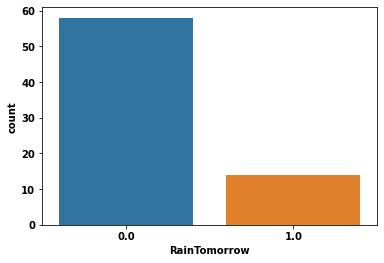

In [389]:
_ = sns.countplot(x='RainTomorrow', data=Y_test) 

## `05`  Finaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaally Training The Model :D 

## `01`Logistic Regression

AUC =  1.0


c:\Users\CRIZMA MEGA STORE\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


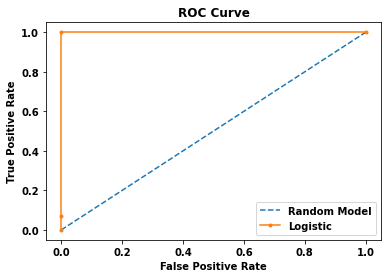

In [390]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

model = LogisticRegression(random_state=42, max_iter=500)
model.fit(X_train, Y_train)

y_pred = model.predict_proba(X_test)
y_pred_prob = y_pred[:, [1]]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
auc = roc_auc_score(Y_test, y_pred_prob)

plt.plot([0,1], [0,1], linestyle='--', label='Random Model')
plt.plot(fpr, tpr, marker='.', label='Logistic')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

print('AUC = ', auc)
plt.show()

In [391]:
# Classification report
print('Train :\n', classification_report(Y_train, model.predict(X_train.values).reshape(-1, 1)))
print('Test :\n', classification_report(Y_test, model.predict(X_test.values).reshape(-1, 1)))

Train :
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       150
         1.0       0.99      0.97      0.98       150

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300

Test :
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        58
         1.0       1.00      1.00      1.00        14

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



## `02` SVC

In [392]:
from sklearn.model_selection import GridSearchCV
 
param_grid = {'C': [0.01, 0.1, 1],
              'kernel': ['linear']}
 
grid = GridSearchCV(SVC(), param_grid, cv = 3)
 
grid.fit(X_train, Y_train.values.ravel())
print("Best hyper_parameters for Linear kernal is : ", grid.best_params_)

Best hyper_parameters for Linear kernal is :  {'C': 1, 'kernel': 'linear'}


In [393]:
svm  = SVC(kernel = 'linear', C = 1)
svm.fit(X_train.values, Y_train.values.ravel())

svm_y_train_pred = svm.predict(X_train.values).reshape(-1, 1)
svm_test_pred = svm.predict(X_test.values).reshape(-1, 1)

print('Train :\n', classification_report(Y_train, svm_y_train_pred))
print('Test :\n', classification_report(Y_test, svm_test_pred))

Train :
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       150
         1.0       1.00      0.99      1.00       150

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

Test :
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        58
         1.0       0.93      0.93      0.93        14

    accuracy                           0.97        72
   macro avg       0.96      0.96      0.96        72
weighted avg       0.97      0.97      0.97        72



## `03` Decision Tree

In [394]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


max_features = [x for x in range(2, 10)]
max_depth = [x for x in range(4, 10)]
ccp_alpha = [x for x in np.linspace(0.0001, 0.01, num = 5)]
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'ccp_alpha': ccp_alpha,
               }

scorer = make_scorer(f1_score)
tree_clf = DecisionTreeClassifier(random_state = 42)

In [395]:
grid_search = GridSearchCV(estimator = tree_clf, 
                           param_grid = random_grid, 
                           scoring = scorer).fit(X_train, Y_train)
grid_search.best_params_

{'ccp_alpha': 0.0001, 'max_depth': 4, 'max_features': 7}

In [396]:
tree_clf = DecisionTreeClassifier(ccp_alpha=0.0001,
                                  max_depth=4,
                                  max_features=7,
                                  random_state = 42)
tree_clf.fit(X_train, Y_train)
tree_y_test_pred = tree_clf.predict(X_test)
tree_y_train_pred = tree_clf.predict(X_train)

print('Train :\n', classification_report(Y_train, tree_y_train_pred))
print('Test :\n', classification_report(Y_test, tree_y_test_pred))

Train :
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       150
         1.0       1.00      1.00      1.00       150

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

Test :
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        58
         1.0       1.00      1.00      1.00        14

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72

